In [ ]:
# default_exp ward_clustering

In [1]:
# export
from multiinstance.utils import *
from multiinstance.distanceApproaches import *
from multiinstance.data.syntheticData import buildDataset,getBag

import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np

import scipy.stats as ss

from tqdm.notebook import tqdm

from numba import set_num_threads

In [ ]:
set_num_threads(10)

In [12]:
# export
class WardClustering:
    def __init__(self, dsi,numbootstraps=10,randomPairing=False):
        self.randomPairing = randomPairing
        self.numbootstraps = numbootstraps
        self.clusterAssignment = np.zeros((dsi.N, dsi.N))
        self.clusterAssignment[0] = np.arange(dsi.N)
        self.clusterAlphaHats = {i: dsi.alphaHats[i] for i in range(dsi.N)}
        self.alphaHatMat = np.ones((dsi.N, dsi.N, numbootstraps)) * np.nan
        for i in range(dsi.N):
            self.alphaHatMat[0,i] = dsi.alphaHats[i]
        self.ds = dsi
        self.meanAbsErrs = np.zeros(dsi.N)
        self.deltas = np.zeros(dsi.N - 1)
        self.doLogging(0)
        self.log = []
        
    def doLogging(self, c_iter):
#         print("logging ",c_iter)
        absErrs = []
        clusters = np.unique(self.clusterAssignment[c_iter])
#         print(self.clusterAssignment)
        for ci in clusters:
            bags = np.where(self.clusterAssignment[c_iter] == ci)[0]
#             print(c_iter, ci)
            aHat = self.alphaHatMat[int(c_iter), int(ci)].mean()
            alphas = self.ds.trueAlphas[bags].flatten()
            # log abs. err for this cluster
            aes = np.abs(alphas - aHat)
            absErrs.append(aes)
        self.meanAbsErrs[c_iter] = np.mean(np.concatenate(absErrs))
#         print("MAE after ",c_iter," merges: ",self.meanAbsErrs)
    
    def cluster(self):
        for c_iter in tqdm(range(1, self.ds.N),desc="clustering iter",total=self.ds.N-1):
            clusters = np.unique(self.clusterAssignment[c_iter - 1]).astype(int)
            Nc = len(clusters)
            deltas = np.ones((Nc, Nc)) * np.inf
            alphaHats_Merged_Clusters = np.zeros((Nc,Nc, self.numbootstraps))
            if not self.randomPairing:
                for i, ci in tqdm(enumerate(clusters), desc="ci", total=Nc, leave=False):
                    alphaHat_ci = self.alphaHatMat[c_iter - 1,ci]
                    var_ci = np.sum((alphaHat_ci - alphaHat_ci.mean())**2)
                    for j, cj in enumerate(set(clusters)):
                        if i != j:
                            alphaHat_cj = self.alphaHatMat[c_iter-1, cj]
                            var_cj = np.sum((alphaHat_cj - alphaHat_cj.mean())**2)
                            # alpha hats from i or j
                            alphaHats = np.concatenate((alphaHat_ci,
                                                           alphaHat_cj))
                            # Get alphaHat for joint cluster
                            bagIdxs = np.where(np.isin(self.clusterAssignment[c_iter - 1],[ci,cj]))[0]
                            alphaHat_cij = self.getClusterEst(bagIdxs)
                            alphaHats_Merged_Clusters[i,j] = alphaHat_cij
                            var_cij = np.sum((alphaHats - alphaHat_cij.mean())**2)
                            deltas[i,j]= var_cij - var_ci - var_cj
                # find indices of bags to merge
                idx = np.argmin(deltas)
                i,j = int(idx / deltas.shape[0]), idx % deltas.shape[0]
            else:
                i = np.random.choice(np.arange(deltas.shape[0]))
                j = np.random.choice(list(set(np.arange(deltas.shape[0])) - set([i])))
                ci = clusters[i]
                cj = clusters[j]
                bagIdxs = np.where(np.isin(self.clusterAssignment[c_iter - 1],[ci,cj]))[0]
                alphaHat_cij = self.getClusterEst(bagIdxs)
                alphaHats_Merged_Clusters[i,j] = alphaHat_cij
                
                
            
            ci, cj = clusters[i], clusters[j]
#             print(deltas)
            self.log.append((ci,cj))
            # deltas i indexed list of increase in cluster variance caused by the i+1_th merge
            self.deltas[c_iter - 1] = deltas[i,j]
            # set cluster assignment after this merge
            self.clusterAssignment[c_iter] = self.clusterAssignment[c_iter - 1]
            inI = np.where(self.clusterAssignment[c_iter] == ci)[0]
            inJ = np.where(self.clusterAssignment[c_iter] == cj)[0]
            self.clusterAssignment[c_iter, inJ] = ci
            # update the alphaHat to that estimated from the newly formed cluster
#             self.clusterAlphaHats[ci] = alphaHats_Merged_Clusters[i,j]
            self.alphaHatMat[c_iter] = self.alphaHatMat[c_iter - 1]
            self.alphaHatMat[c_iter, list(set(inI).union(set(inJ)))] = alphaHats_Merged_Clusters[i,j]
            self.doLogging(c_iter)

    def getClusterEst(self,bagIdxs):
        _,U = list(zip(*[getTransformScores(self.ds,b) for b in bagIdxs]))
        P, _ = list(zip(*[getTransformScores(self.ds,int(i)) for i in range(self.ds.N)]))
        p = np.concatenate(P).reshape((-1,1))
        u = np.concatenate(U).reshape((-1,1))
        alphaHats, _ = getEsts(p,u,self.numbootstraps)
        return alphaHats

In [3]:
dsi = buildDataset(2,alphaDistr=lambda: np.random.uniform(.01,.5),
                  nP=10,nU=25)

dsi = addTransformScores(dsi)

dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=5)

In [13]:
ward = WardClustering(dsi,numbootstraps=5,randomPairing=True)

In [14]:
ward.cluster()

In [24]:
ward.clusterAssignment

array([[0., 1., 2., 3.],
       [2., 1., 2., 3.],
       [1., 1., 1., 3.],
       [1., 1., 1., 1.]])

In [25]:
ward.alphaHatMat

array([[[0.46193406, 0.76291984, 0.14426553, 0.73199731, 0.59609532],
        [0.10491978, 0.06560199, 0.5123148 , 0.21755122, 0.02948518],
        [0.03841695, 0.08404145, 0.7840293 , 0.19662598, 0.19952682],
        [0.25578064, 0.63771969, 0.66250992, 0.56453848, 0.65902776]],

       [[0.59591758, 0.47613329, 0.65192902, 0.31243169, 0.3683635 ],
        [0.10491978, 0.06560199, 0.5123148 , 0.21755122, 0.02948518],
        [0.59591758, 0.47613329, 0.65192902, 0.31243169, 0.3683635 ],
        [0.25578064, 0.63771969, 0.66250992, 0.56453848, 0.65902776]],

       [[0.35314739, 0.31146836, 0.16127411, 0.52021706, 0.53153789],
        [0.35314739, 0.31146836, 0.16127411, 0.52021706, 0.53153789],
        [0.35314739, 0.31146836, 0.16127411, 0.52021706, 0.53153789],
        [0.25578064, 0.63771969, 0.66250992, 0.56453848, 0.65902776]],

       [[0.16790301, 0.57816184, 0.283622  , 0.53855836, 0.31681743],
        [0.16790301, 0.57816184, 0.283622  , 0.53855836, 0.31681743],
        [0.167

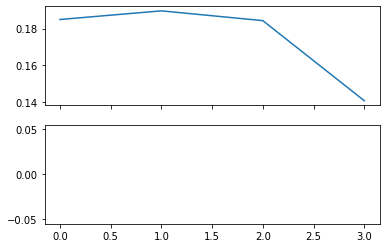

In [26]:
fig, ax= plt.subplots(2,1, sharex=True)
ax[0].plot(ward.meanAbsErrs)
ax[1].plot(np.arange(1, len(ward.deltas) + 1), ward.deltas)